In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dropout, Dense, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")

In [20]:
def load_and_preprocess_data(file_path, lookback_days=30):
    
    data = pd.read_csv("Google_Stock_Price_Train.csv")
    
    # Print column names for verification
    print("Column names in dataset:", data.columns)
    
    # Select the required columns
    expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data = data[expected_columns]
    
    # Remove commas and convert columns to float
    for col in expected_columns:
        data[col] = data[col].replace({',': ''}, regex=True).astype(float)
    
    # Standardize data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Prepare time-series data
    X, y = [], []
    for i in range(lookback_days, len(data_scaled)):
        X.append(data_scaled[i - lookback_days:i])
        y.append(data_scaled[i, 3])  # Predict the closing price
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler, data

# Load data
file_path = 'Google_Stock_Price_Train.csv'  # Replace with the path to your dataset
lookback_days = 30
X, y, scaler, data = load_and_preprocess_data(file_path, lookback_days=lookback_days)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Build LSTM model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Predict closing price
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Set model input shape
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# Define callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')  # Changed filename to .keras
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

# Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(np.concatenate([np.zeros((y_pred_scaled.shape[0], data.shape[1] - 1)), y_pred_scaled], axis=1))[:, -1]

# Calculate Mean Directional Accuracy (MDA)
def mean_directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1]))

mda_score = mean_directional_accuracy(y_test, y_pred)
print("Mean Directional Accuracy:", mda_score)

Column names in dataset: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.8129 - mae: 0.6674 - val_loss: 0.0381 - val_mae: 0.1565
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1376 - mae: 0.2237 - val_loss: 0.0162 - val_mae: 0.1001
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0784 - mae: 0.1694 - val_loss: 0.0178 - val_mae: 0.1037
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0691 - mae: 0.1560 - val_loss: 0.0174 - val_mae: 0.0991
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0608 - mae: 0.1504 - val_loss: 0.0173 - val_mae: 0.1016
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1047 - mae: 0.1712 - val_loss: 0.0446 - val_mae: 0.1895
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0540 - mae: 0.1456 - val_loss: 0.0192 - val_mae: 0.1062
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0515 - mae: 0

In [21]:
def load_and_preprocess_data(file_path, lookback_days=30):
    
    data = pd.read_csv("Google_Stock_Price_Train.csv")
    
    # Print column names for verification
    print("Column names in dataset:", data.columns)
    
    # Select the required columns
    expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data = data[expected_columns]
    
    # Remove commas and convert columns to float
    for col in expected_columns:
        data[col] = data[col].replace({',': ''}, regex=True).astype(float)
    
    # Standardize data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Prepare time-series data
    X, y = [], []
    for i in range(lookback_days, len(data_scaled)):
        X.append(data_scaled[i - lookback_days:i])
        y.append(data_scaled[i, 3])  # Predict the closing price
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler, data

# Load data
file_path = 'Google_Stock_Price_Train.csv'  # Replace with the path to your dataset
lookback_days = 30
X, y, scaler, data = load_and_preprocess_data(file_path, lookback_days=lookback_days)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Build LSTM model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Predict closing price
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Set model input shape
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# Define callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')  # Changed filename to .keras
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

# Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(np.concatenate([np.zeros((y_pred_scaled.shape[0], data.shape[1] - 1)), y_pred_scaled], axis=1))[:, -1]

# Calculate Mean Directional Accuracy (MDA)
def mean_directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1]))

mda_score = mean_directional_accuracy(y_test, y_pred)
print("Mean Directional Accuracy:", mda_score)

Column names in dataset: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.4924 - mae: 0.5110 - val_loss: 0.0263 - val_mae: 0.1232
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1207 - mae: 0.2023 - val_loss: 0.0420 - val_mae: 0.1543
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1081 - mae: 0.1838 - val_loss: 0.0204 - val_mae: 0.1036
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0455 - mae: 0.1417 - val_loss: 0.0306 - val_mae: 0.1541
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0656 - mae: 0.1613 - val_loss: 0.0196 - val_mae: 0.1121
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0775 - mae: 0.1672 - val_loss: 0.0304 - val_mae: 0.1518
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0596 - mae: 0.1468 - val_loss: 0.0185 - val_mae: 0.1039
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0584 - mae: 0

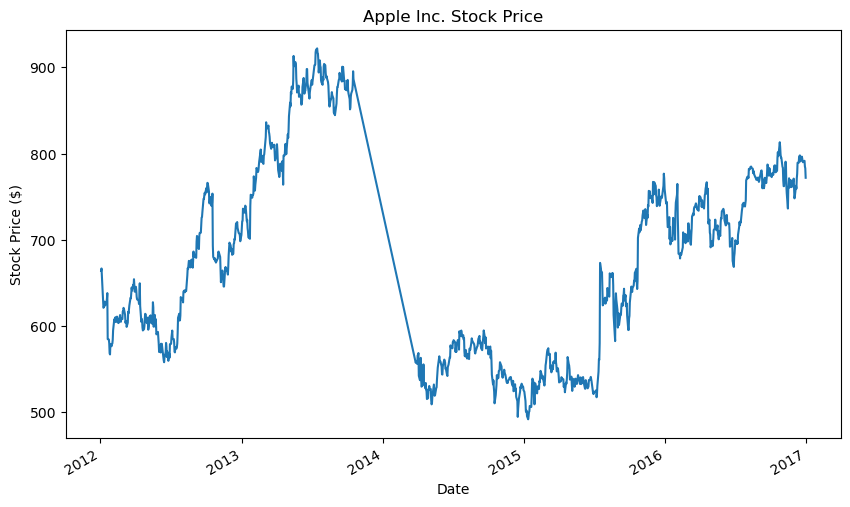

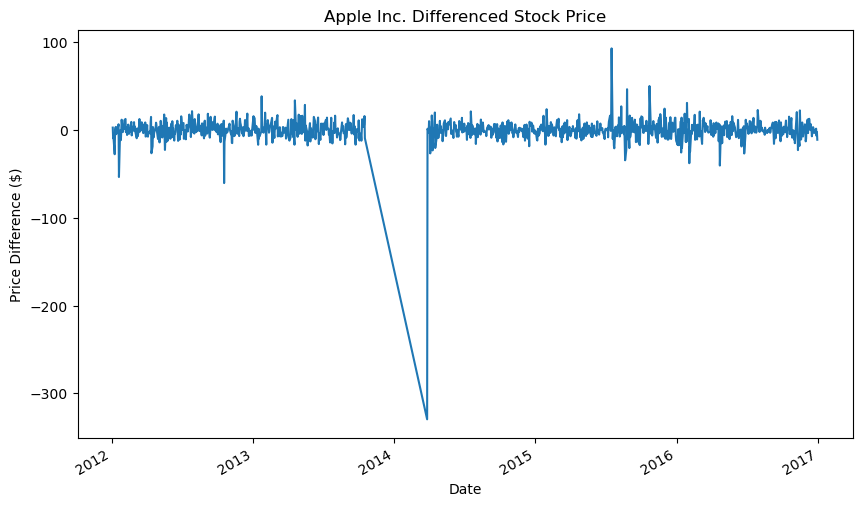

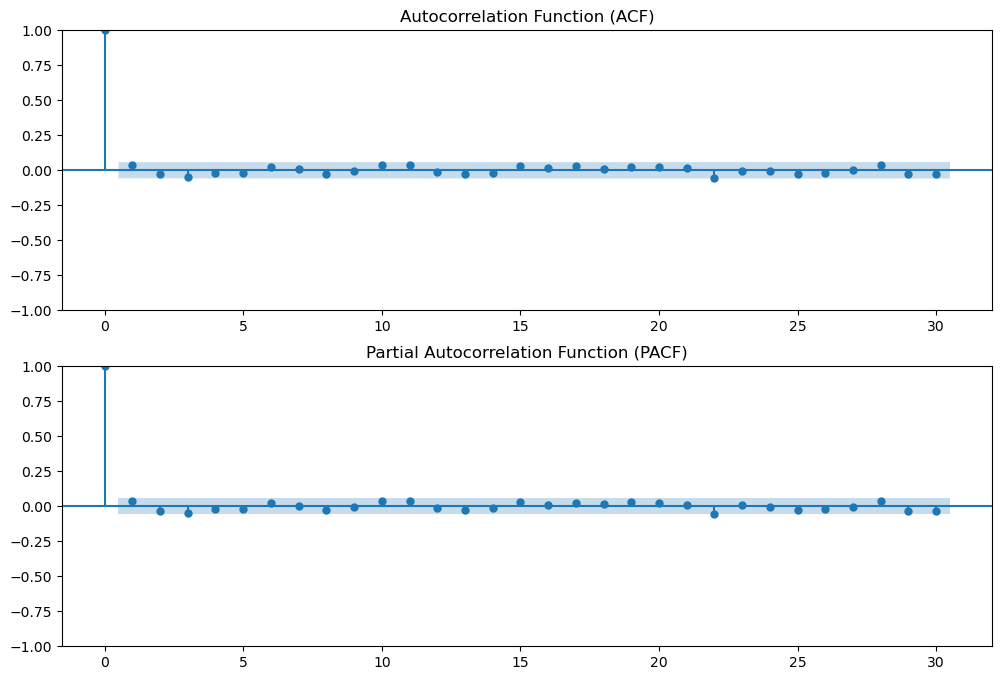

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.4933 - val_loss: 0.0133
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 5.4098e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 5.7893e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 5.1749e-04
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 5.6290e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6767e-04 - val_loss: 5.1515e-04
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 6.1411e-04
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 4.7226e-04
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 4.6454e-04
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 4.6329e-04
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 4.4710e-04
Epoch 12/20
28/28 ━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0066 - val_loss: 4.3705e-04
Epoch 28/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0077 - val_loss: 4.3095e-04
Epoch 29/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0055 - val_loss: 5.2162e-04
Epoch 30/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0065 - val_loss: 4.1053e-04
Epoch 31/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0064 - val_loss: 4.0171e-04
Epoch 32/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0065 - val_loss: 4.0540e-04
Epoch 33/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0055 - val_loss: 4.5139e-04
Epoch 34/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0056 - val_loss: 4.0384e-04
Epoch 35/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0059 - val_loss: 4.2662e-04
Epoch 36/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0078 - val_loss: 4.0344e-04
Epoch 37/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0058 - val_loss: 4.1964e-04
Epoch 38/50
14/14 ━━━━

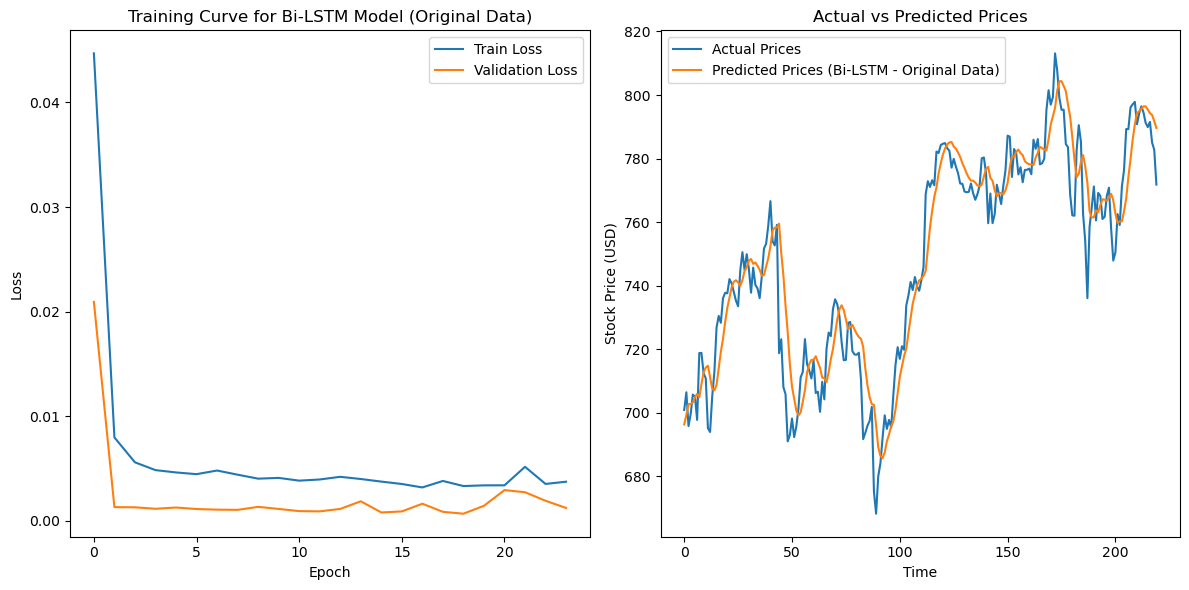

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1296e-04 
Mean Squared Error on Test Set (Bi-LSTM - Original Data): 0.0006916197016835213
Percentage Error (Bi-LSTM - Original Data): 1.1663152755284893%


In [22]:

# Load and visualize data
file_path = 'Google_Stock_Price_Train.csv'  # Replace with the path to your dataset
stock_data = pd.read_csv(file_path)

# Ensure 'Close' is numeric and drop any non-numeric rows
stock_data['Close'] = pd.to_numeric(stock_data['Close'], errors='coerce')
stock_data.dropna(subset=['Close'], inplace=True)

# Convert 'Date' column to datetime and set it as index if it's available
if 'Date' in stock_data.columns:
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)

# Plot original stock price
stock_data['Close'].plot(figsize=(10, 6), title='Apple Inc. Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.show()

# Differencing and plotting ACF/PACF
stock_data['Close_diff'] = stock_data['Close'].diff()
stock_data.dropna(inplace=True)
stock_data['Close_diff'].plot(figsize=(10, 6), title='Apple Inc. Differenced Stock Price')
plt.xlabel('Date')
plt.ylabel('Price Difference ($)')
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(stock_data['Close_diff'], lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(stock_data['Close_diff'], lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.show()

# Sequence creation function
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Differencing and normalization
data_diff = stock_data['Close_diff'].values.reshape(-1, 1)
scaler_diff = MinMaxScaler()
data_diff_normalized = scaler_diff.fit_transform(data_diff)

# Split data into training and testing
train_size_diff = int(len(data_diff_normalized) * 0.8)
train_data_diff, test_data_diff = data_diff_normalized[:train_size_diff], data_diff_normalized[train_size_diff:]

# Sequence length for RNN
seq_length = 40
X_train_diff = create_sequences(train_data_diff, seq_length)
X_test_diff = create_sequences(test_data_diff, seq_length)
y_train_diff = train_data_diff[seq_length:]
y_test_diff = test_data_diff[seq_length:]

# Simple RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='tanh', input_shape=(X_train_diff.shape[1], 1)))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_diff, y_train_diff, epochs=20, batch_size=32, validation_data=(X_test_diff, y_test_diff))

# Improved RNN model with additional layers and dropout
model2 = Sequential()
model2.add(SimpleRNN(units=100, activation='tanh', input_shape=(X_train_diff.shape[1], 1), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(SimpleRNN(units=25, activation='tanh'))
model2.add(Dropout(0.2))
model2.add(Dense(units=1, activation='linear'))
model2.compile(optimizer='adam', loss='mean_squared_error')
history2 = model2.fit(X_train_diff, y_train_diff, epochs=20, batch_size=32, validation_data=(X_test_diff, y_test_diff))

# GRU model
gru_model = Sequential()
gru_model.add(GRU(units=128, activation='tanh', input_shape=(X_train_diff.shape[1], 1), return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=64, activation='tanh'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1, activation='linear'))
optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)
gru_model.compile(optimizer=optimizer, loss='mean_squared_error')
history_gru = gru_model.fit(X_train_diff, y_train_diff, epochs=50, batch_size=64, validation_data=(X_test_diff, y_test_diff))

# Evaluation
y_pred_diff = model2.predict(X_test_diff)
y_pred_improved = scaler_diff.inverse_transform(y_pred_diff)
y_actual_improved = scaler_diff.inverse_transform(y_test_diff)

mse = mean_squared_error(y_actual_improved, y_pred_improved)
mae = mean_absolute_error(y_actual_improved, y_pred_improved)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual_improved, y_pred_improved)
percentage_error = np.mean(np.abs((y_actual_improved - y_pred_improved) / y_actual_improved)) * 100
medae = median_absolute_error(y_actual_improved, y_pred_improved)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared (R2) Score: {r2}')
print(f'Percentage Error: {percentage_error}%')
print(f'Median Absolute Error: {medae}')

# Bi-LSTM model
sequence_length = 10
prices = stock_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
prices_normalized = scaler.fit_transform(prices)
train_data, test_data = prices_normalized[:int(len(prices_normalized) * 0.8)], prices_normalized[int(len(prices_normalized) * 0.8):]
X_train = create_sequences(train_data, sequence_length)
X_test = create_sequences(test_data, sequence_length)
y_train = train_data[sequence_length:]
y_test = test_data[sequence_length:]

bi_lstm_model_original = Sequential()
bi_lstm_model_original.add(Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True), input_shape=(sequence_length, 1)))
bi_lstm_model_original.add(Dropout(0.2))
bi_lstm_model_original.add(Bidirectional(LSTM(units=64, activation='tanh')))
bi_lstm_model_original.add(Dropout(0.2))
bi_lstm_model_original.add(Dense(units=1, activation='linear'))
optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
bi_lstm_model_original.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_bi_lstm_original = bi_lstm_model_original.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plotting and prediction visualization
y_pred_bi_lstm_original = bi_lstm_model_original.predict(X_test)
y_pred_original = scaler.inverse_transform(y_pred_bi_lstm_original.reshape(-1, 1))
y_actual_original = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_bi_lstm_original.history['loss'], label='Train Loss')
plt.plot(history_bi_lstm_original.history['val_loss'], label='Validation Loss')
plt.title('Training Curve for Bi-LSTM Model (Original Data)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_actual_original, label='Actual Prices')
plt.plot(y_pred_original, label='Predicted Prices (Bi-LSTM - Original Data)')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()

plt.tight_layout()
plt.show()

# Additional error metrics
loss_bi_lstm_original = bi_lstm_model_original.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set (Bi-LSTM - Original Data): {loss_bi_lstm_original}')
percentage_error_bi_lstm_original = np.mean(np.abs((y_actual_original - y_pred_original) / y_actual_original)) * 100
print(f'Percentage Error (Bi-LSTM - Original Data): {percentage_error_bi_lstm_original}%')

Initial data shape: (1258, 6)

First few rows of data:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

Data types:
Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

Data types after conversion:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

Missing values after conversion:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Final data shape after cleaning: (1258, 6)

Dataset splits:
Training sequences: 976
Validation sequences: 95
Test sequences: 97
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 80

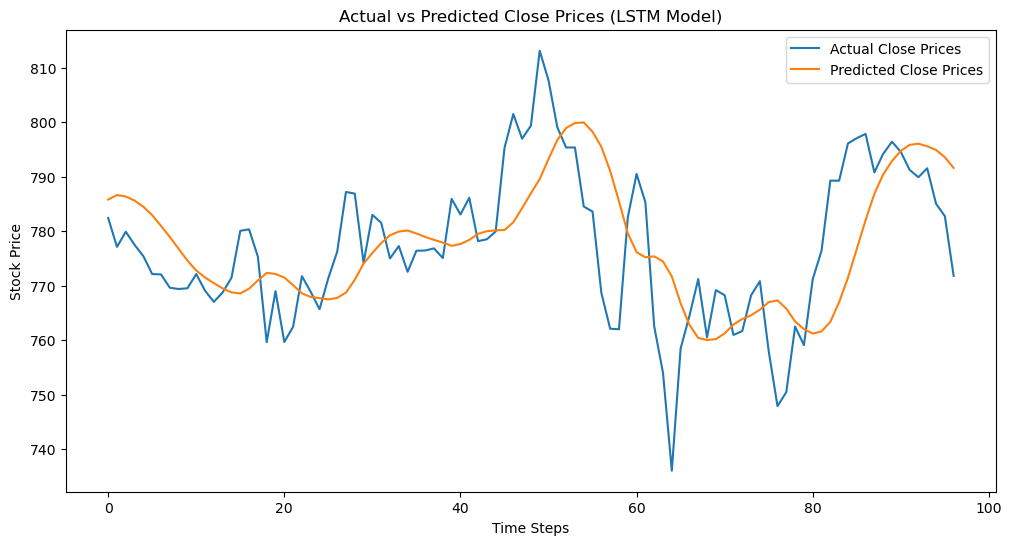

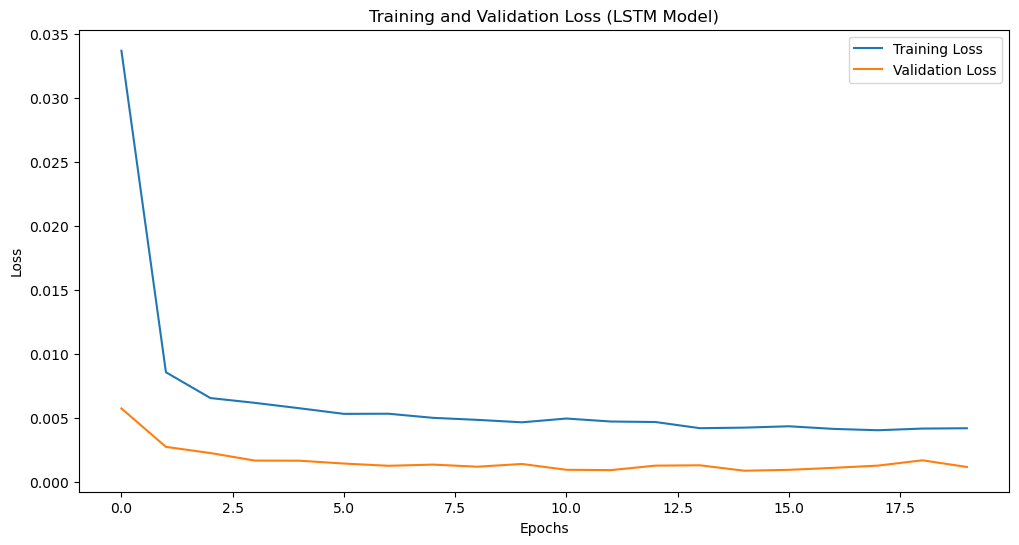

In [28]:

# Load the dataset
file_path = 'Google_Stock_Price_Train.csv'
stock_data = pd.read_csv(file_path)

# Print initial data info for debugging
print("Initial data shape:", stock_data.shape)
print("\nFirst few rows of data:")
print(stock_data.head())
print("\nColumns:", stock_data.columns.tolist())
print("\nData types:")
print(stock_data.dtypes)

# Convert data types and handle missing values
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Check if columns exist in the dataset
available_columns = [col for col in numeric_columns if col in stock_data.columns]
if not available_columns:
    raise ValueError(f"None of the required columns {numeric_columns} found in the dataset")

# Improved numeric conversion function
def convert_to_numeric(series):
    if series.dtype == object:  # If string/object type
        # First remove any currency symbols, spaces, and commas
        cleaned = series.replace('[\$,\s]', '', regex=True)
        return pd.to_numeric(cleaned, errors='coerce')
    else:  # If already numeric
        return series

# Convert to numeric and handle missing values
for col in available_columns:
    stock_data[col] = convert_to_numeric(stock_data[col])

# Print info after conversion
print("\nData types after conversion:")
print(stock_data[available_columns].dtypes)
print("\nMissing values after conversion:")
print(stock_data[available_columns].isnull().sum())

# Drop rows with missing values
stock_data.dropna(subset=available_columns, inplace=True)

# Verify we have data after cleaning
if len(stock_data) == 0:
    raise ValueError("No data remaining after cleaning. Please check your input data.")

print(f"\nFinal data shape after cleaning: {stock_data.shape}")

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stock_data[available_columns])

# Split the data into training, validation, and test sets
seq_length = 30  # Use past 30 days
train_ratio = 0.8
val_ratio = 0.1

# Calculate dataset sizes
total_data = len(scaled_data)
train_size = int(total_data * train_ratio)
val_size = int(total_data * val_ratio)
test_size = total_data - train_size - val_size

# Ensure we have enough data for all splits
if train_size < seq_length or val_size < seq_length or test_size < seq_length:
    raise ValueError(f"Not enough data for the chosen sequence length ({seq_length})")

# Split the data
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]

def create_multivariate_sequences(data, seq_length, pred_steps):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + pred_steps, :])
    return np.array(X), np.array(y)

# Create sequences
pred_steps = 1
X_train, y_train = create_multivariate_sequences(train_data, seq_length, pred_steps)
X_val, y_val = create_multivariate_sequences(val_data, seq_length, pred_steps)
X_test, y_test = create_multivariate_sequences(test_data, seq_length, pred_steps)

# Reshape target variables
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

# Print dataset information
print("\nDataset splits:")
print(f"Training sequences: {len(X_train)}")
print(f"Validation sequences: {len(X_val)}")
print(f"Test sequences: {len(X_test)}")

# Build and train model only if we have sufficient data
if len(X_train) > 0 and len(X_val) > 0 and len(X_test) > 0:
    # Build LSTM Model
    lstm_model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
        Dropout(0.2),
        LSTM(64, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(y_train.shape[1], activation='linear')
    ])

    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = lstm_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate and plot results
    y_pred = lstm_model.predict(X_test)

    # Reverse scaling for evaluation
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))

    # Calculate metrics for the "Close" price
    close_price_index = available_columns.index('Close')
    mse = mean_squared_error(y_test_inverse[:, close_price_index], y_pred_inverse[:, close_price_index])
    mae = mean_absolute_error(y_test_inverse[:, close_price_index], y_pred_inverse[:, close_price_index])
    r2 = r2_score(y_test_inverse[:, close_price_index], y_pred_inverse[:, close_price_index])
    percentage_error = np.mean(np.abs((y_test_inverse[:, close_price_index] - y_pred_inverse[:, close_price_index]) 
                                    / y_test_inverse[:, close_price_index])) * 100

    print("\nModel Performance Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Percentage Error: {percentage_error:.2f}%")

    # Plot predictions vs actual prices
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inverse[:, close_price_index], label='Actual Close Prices')
    plt.plot(y_pred_inverse[:, close_price_index], label='Predicted Close Prices')
    plt.title("Actual vs Predicted Close Prices (LSTM Model)")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss (LSTM Model)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
else:
    print("Not enough data to train the model. Please check your input data.")

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0846 - val_loss: 0.0194
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0102 - val_loss: 9.6419e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0097 - val_loss: 0.0043
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0051 - val_loss: 9.6330e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0047 - val_loss: 6.8738e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0048 - val_loss: 6.7420e-04
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0074 - val_loss: 8.2793e-04
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0046 - val_loss: 7.6068e-04
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 

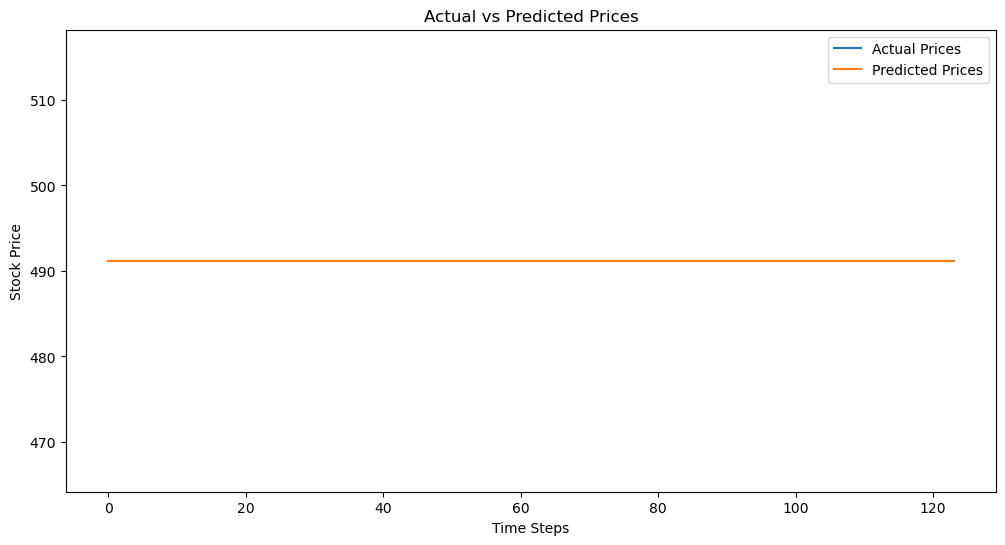

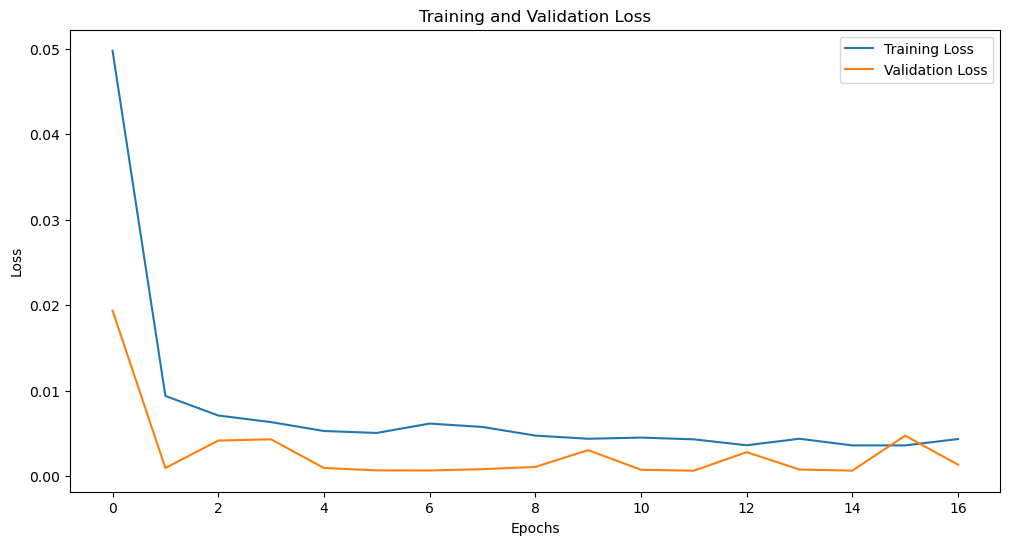

In [29]:
# Function to load and preprocess data
def load_and_preprocess_data(file_path, seq_length=30):
    # Load data
    data = pd.read_csv(file_path)
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Convert columns to numeric
    for col in numeric_columns:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col].replace({',': ''}, regex=True), errors='coerce')
    
    # Drop rows with missing values
    data.dropna(subset=numeric_columns, inplace=True)
    
    # Normalize data
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[numeric_columns])
    
    # Create sequences
    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i + seq_length])
        y.append(data_scaled[i + seq_length, numeric_columns.index('Close')])
    
    return np.array(X), np.array(y), scaler, numeric_columns

# Function to build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Load data
file_path = 'Google_Stock_Price_Train.csv'
seq_length = 30
X, y, scaler, numeric_columns = load_and_preprocess_data(file_path, seq_length)

# Split data into training, validation, and test sets
train_ratio, val_ratio = 0.8, 0.1
train_size = int(len(X) * train_ratio)
val_size = int(len(X) * val_ratio)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Build and train the model
model = build_lstm_model((seq_length, X.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate and predict
y_pred = model.predict(X_test)

# Reverse scaling for evaluation
y_pred_inverse = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), len(numeric_columns) - 1)), y_pred], axis=1)
)[:, numeric_columns.index('Close')]

y_test_inverse = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), len(numeric_columns) - 1)), y_test.reshape(-1, 1)], axis=1)
)[:, numeric_columns.index('Close')]
# Calculate metrics
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [30]:

# 加载和预处理数据
def load_and_preprocess_data(file_path, lookback_days=30):
    data = pd.read_csv(file_path)
    
    # 打印列名以供确认
    print("Column names in dataset:", data.columns)
    
    # 选择所需的列
    expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data = data[expected_columns]
    
    # 去除逗号并将列转换为浮点数
    for col in expected_columns:
        data[col] = data[col].replace({',': ''}, regex=True).astype(float)
    
    # 标准化数据
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # 准备时间序列数据
    X, y = [], []
    for i in range(lookback_days, len(data_scaled)):
        X.append(data_scaled[i - lookback_days:i])
        y.append(data_scaled[i, 3])  # 预测收盘价
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler, data

# 构建LSTM模型
def build_lstm_model(input_shape, units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(Input(shape=input_shape))  # 使用 Input 层定义输入形状
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # 输出层，预测收盘价
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# 计算方向性准确率（Mean Directional Accuracy）
def mean_directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1]))

# 加载数据
file_path = 'Google_Stock_Price_Train.csv'  # 替换为你的数据集路径
lookback_days = 30
X, y, scaler, data = load_and_preprocess_data(file_path, lookback_days=lookback_days)

# 拆分数据为训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# 定义模型输入形状
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# 定义回调函数
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

# 训练模型
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

# 测试模型
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

# 预测并反标准化
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(
    np.concatenate([np.zeros((y_pred_scaled.shape[0], data.shape[1] - 1)), y_pred_scaled], axis=1)
)[:, -1]

# 计算方向性准确率
mda_score = mean_directional_accuracy(y_test, y_pred)
print("Mean Directional Accuracy:", mda_score)


Column names in dataset: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.4842 - mae: 0.4935 - val_loss: 0.0585 - val_mae: 0.1922
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1280 - mae: 0.2061 - val_loss: 0.0219 - val_mae: 0.1099
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1161 - mae: 0.1866 - val_loss: 0.0188 - val_mae: 0.1059
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0735 - mae: 0.1650 - val_loss: 0.0210 - val_mae: 0.1034
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0642 - mae: 0.1482 - val_loss: 0.0201 - val_mae: 0.1196
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0784 - mae: 0.1536 - val_loss: 0.0187 - val_mae: 0.1053
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0508 - mae: 0.1364 - val_loss: 0.0186 - val_mae: 0.1010
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0789 - mae: 0

Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0350 - mae: 0.1048 - val_loss: 0.0092 - val_mae: 0.0719
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0380 - mae: 0.1086 - val_loss: 0.0099 - val_mae: 0.0749
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0224 - mae: 0.0985 - val_loss: 0.0240 - val_mae: 0.1382
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0448 - mae: 0.1131 - val_loss: 0.0102 - val_mae: 0.0735
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0230 - mae: 0.1031 - val_loss: 0.0093 - val_mae: 0.0734
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0232 - mae: 0.1041 - val_loss: 0.0101 - val_mae: 0.0766
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0434 
Test Loss: 0.004853594116866589
Test MAE: 0.05064021423459053
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Mean Directional Accuracy: 0.5


In [31]:


# Function to load and preprocess data
def load_and_preprocess_data(file_path, lookback_days=30):
    # Load dataset
    data = pd.read_csv(file_path)
    
    # Print column names for verification
    print("Column names in dataset:", data.columns)
    
    # Select the required columns
    expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data = data[expected_columns]
    
    # Remove commas and convert columns to float
    for col in expected_columns:
        data[col] = data[col].replace({',': ''}, regex=True).astype(float)
    
    # Standardize data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Prepare time-series data
    X, y = [], []
    for i in range(lookback_days, len(data_scaled)):
        X.append(data_scaled[i - lookback_days:i])
        y.append(data_scaled[i, 3])  # Predict the closing price
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler, data

# Load data
file_path = 'Google_Stock_Price_Train.csv'  # Replace with the path to your dataset
lookback_days = 30
X, y, scaler, data = load_and_preprocess_data(file_path, lookback_days=lookback_days)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Build LSTM model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units=units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units=units),
        Dropout(dropout_rate),
        Dense(1)  # Predict closing price
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Set model input shape
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# Define callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')  # Changed filename to .keras
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

# Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(
    np.concatenate([np.zeros((y_pred_scaled.shape[0], data.shape[1] - 1)), y_pred_scaled], axis=1)
)[:, -1]

# Calculate Mean Directional Accuracy (MDA)
def mean_directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1]))

mda_score = mean_directional_accuracy(y_test, y_pred)
print("Mean Directional Accuracy:", mda_score)


Column names in dataset: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.7204 - mae: 0.6138 - val_loss: 0.0355 - val_mae: 0.1401
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1152 - mae: 0.2314 - val_loss: 0.0221 - val_mae: 0.1219
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1380 - mae: 0.2039 - val_loss: 0.0369 - val_mae: 0.1394
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0811 - mae: 0.1662 - val_loss: 0.0211 - val_mae: 0.1137
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0565 - mae: 0.1528 - val_loss: 0.0232 - val_mae: 0.1277
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0626 - mae: 0.1472 - val_loss: 0.0237 - val_mae: 0.1269
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0552 - mae: 0.1426 - val_loss: 0.0246 - val_mae: 0.1292
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0658 - mae: 0

Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0384 - mae: 0.1079 - val_loss: 0.0102 - val_mae: 0.0736
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0218 - mae: 0.0998 - val_loss: 0.0109 - val_mae: 0.0826
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0253 - mae: 0.0986 - val_loss: 0.0141 - val_mae: 0.0921
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0307 - mae: 0.1052 - val_loss: 0.0084 - val_mae: 0.0706
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0223 - mae: 0.0990 - val_loss: 0.0106 - val_mae: 0.0821
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0609 - mae: 0.1206 - val_loss: 0.0095 - val_mae: 0.0723
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0239 - mae: 0.1016 - val_loss: 0.0113 - val_mae: 0.0827
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0283 - mae: 0.1048 - val_loss: 0.0116 - val_mae: 0.0840
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/

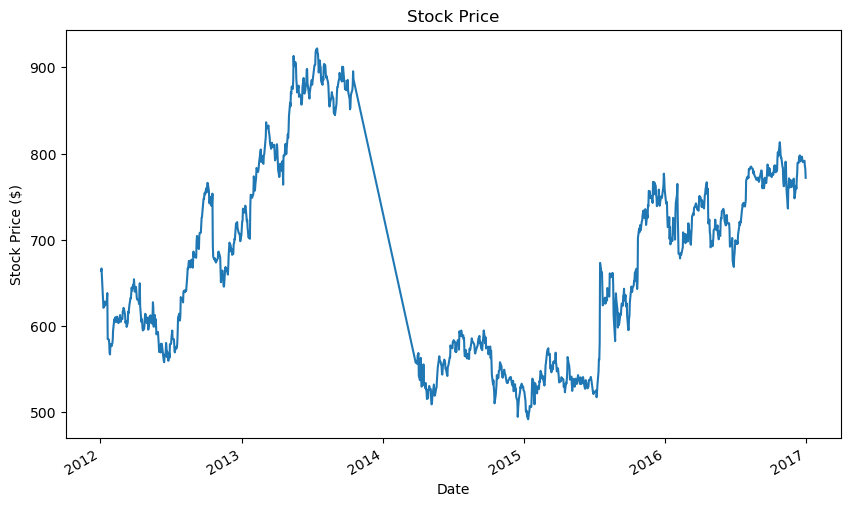

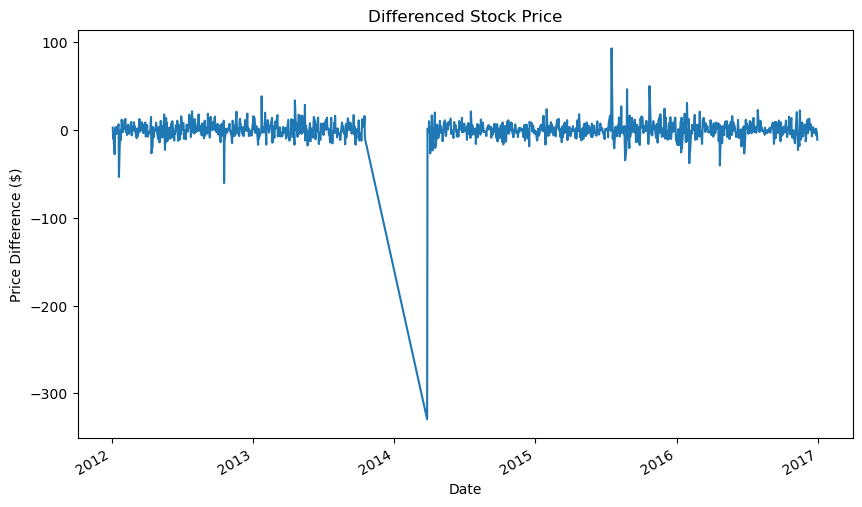

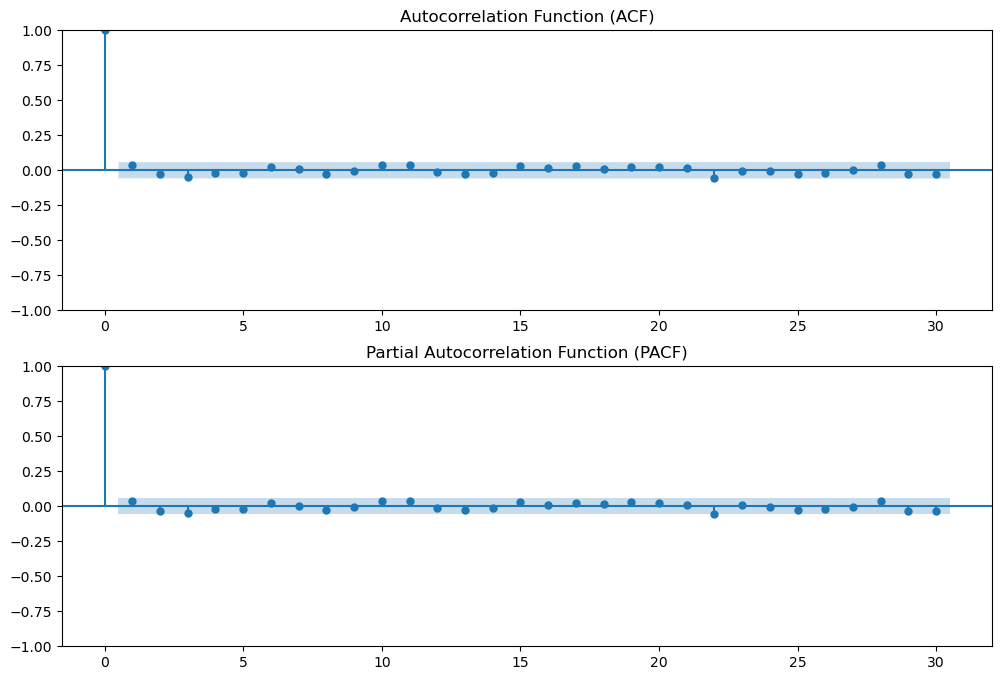

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2745 - val_loss: 0.0078
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 6.9435e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 4.2190e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 3.9292e-04
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3717e-04 - val_loss: 4.5121e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 3.9972e-04
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 4.3528e-04
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 3.9029e-04
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 3.8352e-04
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 3.9108e-04
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 4.2331e-04
Epoch 12/20
28/28 ━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0068 - val_loss: 4.0015e-04
Epoch 29/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0063 - val_loss: 4.6322e-04
Epoch 30/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0059 - val_loss: 4.1341e-04
Epoch 31/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0054 - val_loss: 4.1739e-04
Epoch 32/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0056 - val_loss: 4.1431e-04
Epoch 33/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0052 - val_loss: 4.5530e-04
Epoch 34/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0053 - val_loss: 4.1452e-04
Epoch 35/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0064 - val_loss: 4.2219e-04
Epoch 36/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0070 - val_loss: 4.1653e-04
Epoch 37/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0052 - val_loss: 4.0651e-04
Epoch 38/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0063 - val_loss: 4.4067e-04
Epoch 39/50
14/14 ━━━━

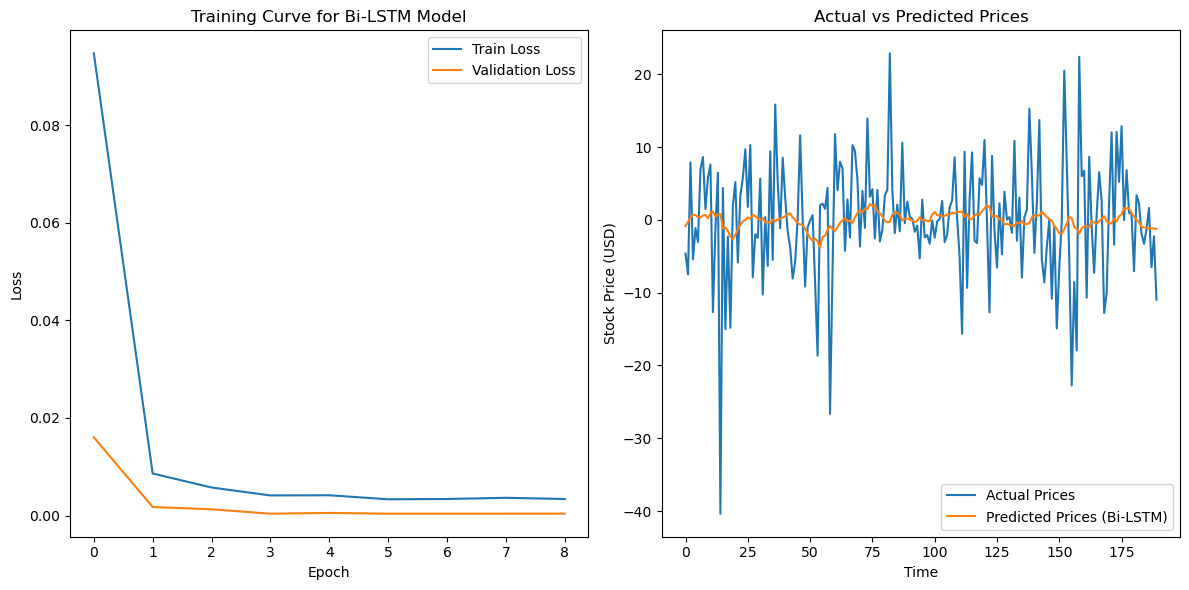

Mean Squared Error: 66.84705963456783
Percentage Error: 198.4160515829568%


In [32]:

# 加载和可视化数据
file_path = 'Google_Stock_Price_Train.csv'  # 替换为你的数据集路径
stock_data = pd.read_csv(file_path)

# 确保 'Close' 是数值类型，并删除非数值行
stock_data['Close'] = pd.to_numeric(stock_data['Close'], errors='coerce')
stock_data.dropna(subset=['Close'], inplace=True)

# 如果 'Date' 列存在，将其转换为日期时间格式并设为索引
if 'Date' in stock_data.columns:
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)

# 原始股票价格绘图
stock_data['Close'].plot(figsize=(10, 6), title='Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.show()

# 一阶差分和 ACF/PACF 绘图
stock_data['Close_diff'] = stock_data['Close'].diff()
stock_data.dropna(inplace=True)
stock_data['Close_diff'].plot(figsize=(10, 6), title='Differenced Stock Price')
plt.xlabel('Date')
plt.ylabel('Price Difference ($)')
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(stock_data['Close_diff'], lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(stock_data['Close_diff'], lags=30, ax=ax2, method='ywm')  # 修复警告
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.show()

# 序列生成函数
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# 差分和归一化
data_diff = stock_data['Close_diff'].values.reshape(-1, 1)
scaler_diff = MinMaxScaler()
data_diff_normalized = scaler_diff.fit_transform(data_diff)

# 数据集划分
train_size_diff = int(len(data_diff_normalized) * 0.8)
train_data_diff, test_data_diff = data_diff_normalized[:train_size_diff], data_diff_normalized[train_size_diff:]

# RNN 的序列长度
seq_length = 40
X_train_diff = create_sequences(train_data_diff, seq_length)
X_test_diff = create_sequences(test_data_diff, seq_length)
y_train_diff = train_data_diff[seq_length:]
y_test_diff = test_data_diff[seq_length:]

# 简单 RNN 模型
model = Sequential()
model.add(Input(shape=(X_train_diff.shape[1], 1)))  # 使用 Input 层定义输入形状
model.add(SimpleRNN(units=50, activation='tanh'))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_diff, y_train_diff, epochs=20, batch_size=32, validation_data=(X_test_diff, y_test_diff))

# 改进版 RNN 模型
model2 = Sequential()
model2.add(Input(shape=(X_train_diff.shape[1], 1)))  # 使用 Input 层定义输入形状
model2.add(SimpleRNN(units=100, activation='tanh', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(SimpleRNN(units=25, activation='tanh'))
model2.add(Dropout(0.2))
model2.add(Dense(units=1, activation='linear'))
model2.compile(optimizer='adam', loss='mean_squared_error')
history2 = model2.fit(X_train_diff, y_train_diff, epochs=20, batch_size=32, validation_data=(X_test_diff, y_test_diff))

# GRU 模型
gru_model = Sequential()
gru_model.add(Input(shape=(X_train_diff.shape[1], 1)))  # 使用 Input 层定义输入形状
gru_model.add(GRU(units=128, activation='tanh', return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=64, activation='tanh'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1, activation='linear'))
optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)
gru_model.compile(optimizer=optimizer, loss='mean_squared_error')
history_gru = gru_model.fit(X_train_diff, y_train_diff, epochs=50, batch_size=64, validation_data=(X_test_diff, y_test_diff))

# Bi-LSTM 模型
bi_lstm_model = Sequential()
bi_lstm_model.add(Input(shape=(seq_length, 1)))
bi_lstm_model.add(Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Bidirectional(LSTM(units=64, activation='tanh')))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Dense(units=1, activation='linear'))
optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
bi_lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_bi_lstm = bi_lstm_model.fit(X_train_diff, y_train_diff, epochs=50, batch_size=64, validation_data=(X_test_diff, y_test_diff), callbacks=[early_stopping])

# 结果评估
y_pred_bi_lstm = bi_lstm_model.predict(X_test_diff)
y_pred = scaler_diff.inverse_transform(y_pred_bi_lstm)
y_actual = scaler_diff.inverse_transform(y_test_diff)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_bi_lstm.history['loss'], label='Train Loss')
plt.plot(history_bi_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training Curve for Bi-LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_actual, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices (Bi-LSTM)')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()

plt.tight_layout()
plt.show()

# 计算误差指标
mse = mean_squared_error(y_actual, y_pred)
percentage_error = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
print(f'Mean Squared Error: {mse}')
print(f'Percentage Error: {percentage_error}%')


Initial data shape: (1258, 6)

First few rows of data:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

Data types:
Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

Data types after conversion:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

Missing values after conversion:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Final data shape after cleaning: (1258, 6)

Dataset splits:
Training sequences: 976
Validation sequences: 95
Test sequences: 97
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 71

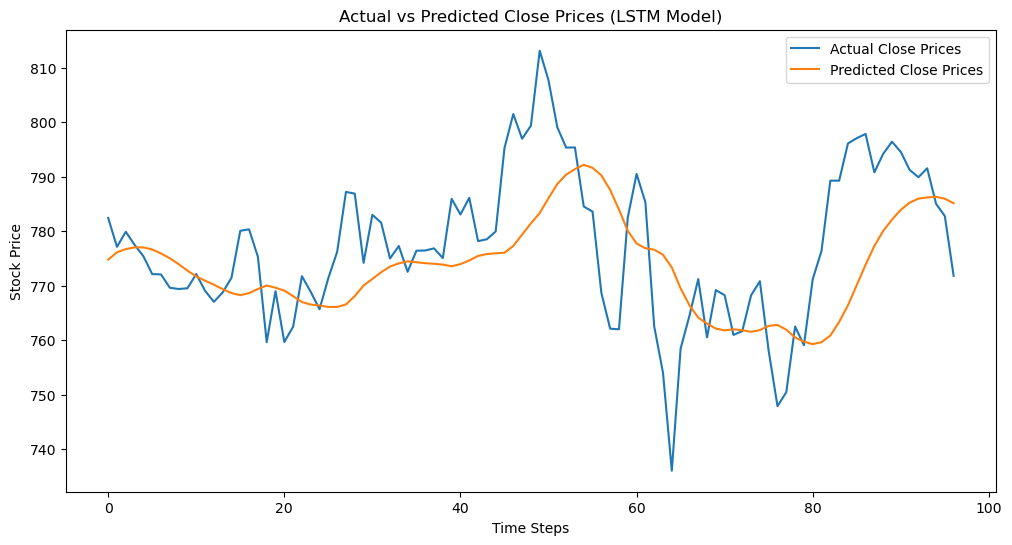

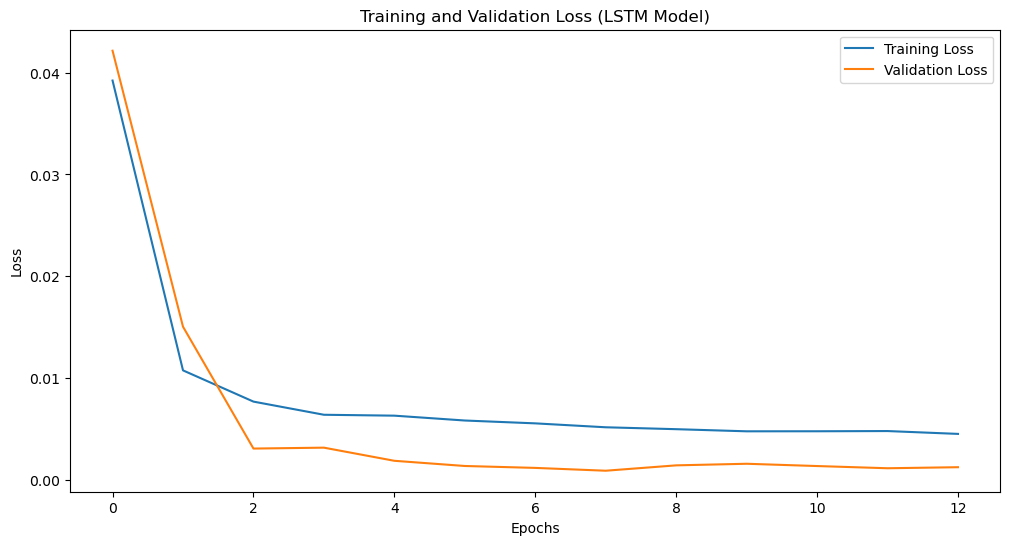

In [33]:


# Load the dataset
file_path = 'Google_Stock_Price_Train.csv'
stock_data = pd.read_csv(file_path)

# Print initial data info for debugging
print("Initial data shape:", stock_data.shape)
print("\nFirst few rows of data:")
print(stock_data.head())
print("\nColumns:", stock_data.columns.tolist())
print("\nData types:")
print(stock_data.dtypes)

# Convert data types and handle missing values
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Check if columns exist in the dataset
available_columns = [col for col in numeric_columns if col in stock_data.columns]
if not available_columns:
    raise ValueError(f"None of the required columns {numeric_columns} found in the dataset")

# Improved numeric conversion function
def convert_to_numeric(series):
    if series.dtype == object:  # If string/object type
        # Remove any currency symbols, spaces, and commas
        cleaned = series.replace('[\$,\s]', '', regex=True)
        return pd.to_numeric(cleaned, errors='coerce')
    else:  # If already numeric
        return series

# Convert to numeric and handle missing values
for col in available_columns:
    stock_data[col] = convert_to_numeric(stock_data[col])

# Print info after conversion
print("\nData types after conversion:")
print(stock_data[available_columns].dtypes)
print("\nMissing values after conversion:")
print(stock_data[available_columns].isnull().sum())

# Drop rows with missing values
stock_data.dropna(subset=available_columns, inplace=True)

# Verify we have data after cleaning
if len(stock_data) == 0:
    raise ValueError("No data remaining after cleaning. Please check your input data.")

print(f"\nFinal data shape after cleaning: {stock_data.shape}")

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stock_data[available_columns])

# Split the data into training, validation, and test sets
seq_length = 30  # Use past 30 days
train_ratio = 0.8
val_ratio = 0.1

# Calculate dataset sizes
total_data = len(scaled_data)
train_size = int(total_data * train_ratio)
val_size = int(total_data * val_ratio)
test_size = total_data - train_size - val_size

# Ensure we have enough data for all splits
if train_size < seq_length or val_size < seq_length or test_size < seq_length:
    raise ValueError(f"Not enough data for the chosen sequence length ({seq_length})")

# Split the data
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]

def create_multivariate_sequences(data, seq_length, pred_steps):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + pred_steps, :])
    return np.array(X), np.array(y)

# Create sequences
pred_steps = 1
X_train, y_train = create_multivariate_sequences(train_data, seq_length, pred_steps)
X_val, y_val = create_multivariate_sequences(val_data, seq_length, pred_steps)
X_test, y_test = create_multivariate_sequences(test_data, seq_length, pred_steps)

# Reshape target variables
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

# Print dataset information
print("\nDataset splits:")
print(f"Training sequences: {len(X_train)}")
print(f"Validation sequences: {len(X_val)}")
print(f"Test sequences: {len(X_test)}")

# Build and train model only if we have sufficient data
if len(X_train) > 0 and len(X_val) > 0 and len(X_test) > 0:
    # Build LSTM Model
    lstm_model = Sequential([
        Input(shape=(seq_length, X_train.shape[2])),  # Explicitly define input shape
        LSTM(128, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(64, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(y_train.shape[1], activation='linear')
    ])

    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = lstm_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate and plot results
    y_pred = lstm_model.predict(X_test)

    # Reverse scaling for evaluation
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))

    # Calculate metrics for the "Close" price
    close_price_index = available_columns.index('Close')
    mse = mean_squared_error(y_test_inverse[:, close_price_index], y_pred_inverse[:, close_price_index])
    mae = mean_absolute_error(y_test_inverse[:, close_price_index], y_pred_inverse[:, close_price_index])
    r2 = r2_score(y_test_inverse[:, close_price_index], y_pred_inverse[:, close_price_index])
    percentage_error = np.mean(np.abs((y_test_inverse[:, close_price_index] - y_pred_inverse[:, close_price_index]) 
                                    / y_test_inverse[:, close_price_index])) * 100

    print("\nModel Performance Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Percentage Error: {percentage_error:.2f}%")

    # Plot predictions vs actual prices
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inverse[:, close_price_index], label='Actual Close Prices')
    plt.plot(y_pred_inverse[:, close_price_index], label='Predicted Close Prices')
    plt.title("Actual vs Predicted Close Prices (LSTM Model)")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss (LSTM Model)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
else:
    print("Not enough data to train the model. Please check your input data.")


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0691 - val_loss: 0.0013
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0050 - val_loss: 7.9623e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0061 - val_loss: 0.0013
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0062 - val_loss: 7.5226e-04
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0042 - val_loss: 7.3990e-04
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

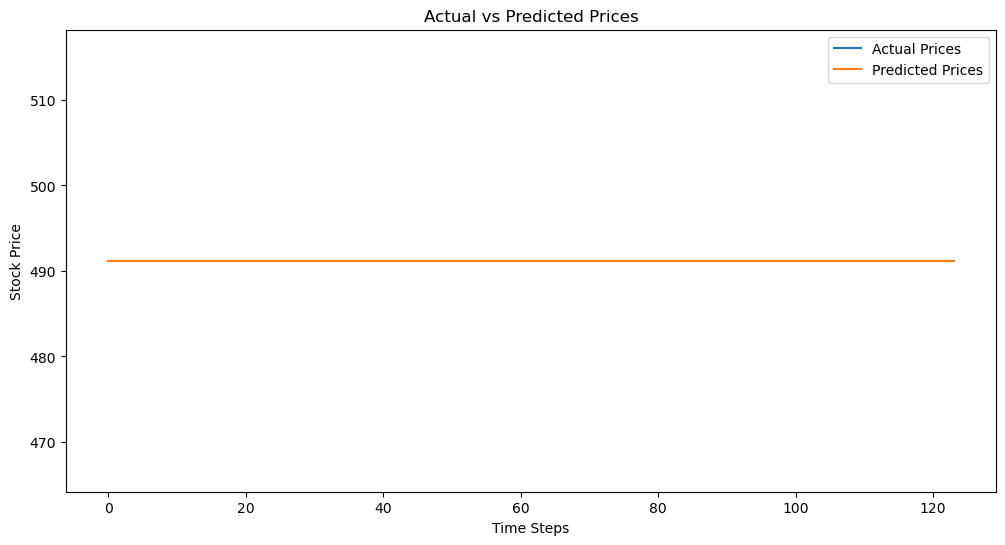

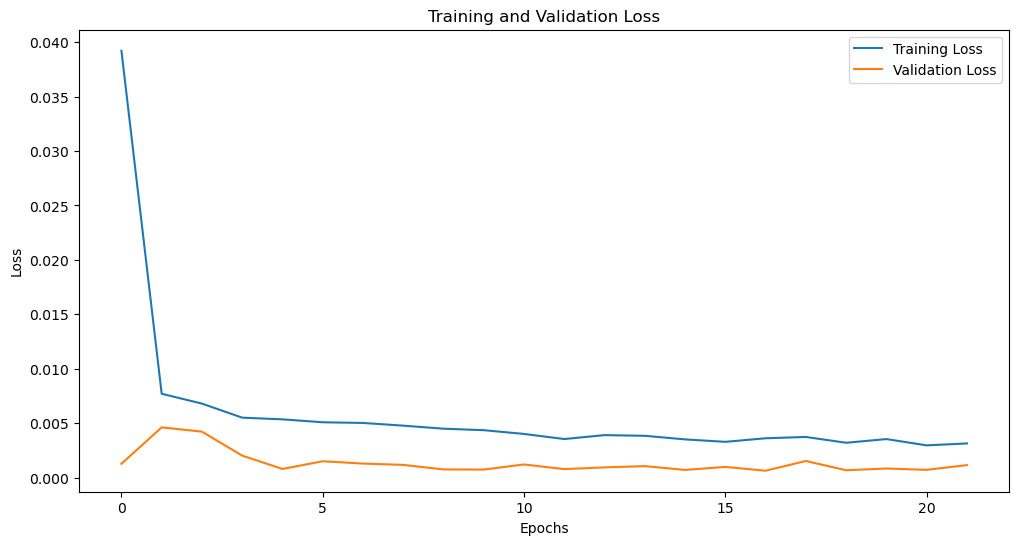

In [34]:


# Function to load and preprocess data
def load_and_preprocess_data(file_path, seq_length=30):
    # Load data
    data = pd.read_csv(file_path)
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Convert columns to numeric
    for col in numeric_columns:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col].replace({',': ''}, regex=True), errors='coerce')
    
    # Drop rows with missing values
    data.dropna(subset=numeric_columns, inplace=True)
    
    # Normalize data
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[numeric_columns])
    
    # Create sequences
    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i + seq_length])
        y.append(data_scaled[i + seq_length, numeric_columns.index('Close')])
    
    return np.array(X), np.array(y), scaler, numeric_columns

# Function to build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(64, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Load data
file_path = 'Google_Stock_Price_Train.csv'
seq_length = 30
X, y, scaler, numeric_columns = load_and_preprocess_data(file_path, seq_length)

# Split data into training, validation, and test sets
train_ratio, val_ratio = 0.8, 0.1
train_size = int(len(X) * train_ratio)
val_size = int(len(X) * val_ratio)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Build and train the model
model = build_lstm_model((seq_length, X.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate and predict
y_pred = model.predict(X_test)

# Reverse scaling for evaluation
y_pred_inverse = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), len(numeric_columns) - 1)), y_pred], axis=1)
)[:, numeric_columns.index('Close')]

y_test_inverse = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), len(numeric_columns) - 1)), y_test.reshape(-1, 1)], axis=1)
)[:, numeric_columns.index('Close')]

# Calculate metrics
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
